In [1]:
import tensorflow as tf
import PIL
import time

In [2]:
from keras.applications import VGG16
from keras.callbacks import ModelCheckpoint,TensorBoard

Using TensorFlow backend.


In [3]:
vgg_conv = VGG16(weights='imagenet',include_top=False,input_shape=(256, 256, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-3]:
    layer.trainable = False

In [5]:
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001E8EF94EC18> False
<keras.layers.convolutional.Conv2D object at 0x000001E8F0E64668> False
<keras.layers.convolutional.Conv2D object at 0x000001E8F0E644E0> False
<keras.layers.pooling.MaxPooling2D object at 0x000001E8F0E86860> False
<keras.layers.convolutional.Conv2D object at 0x000001E8F0E86B38> False
<keras.layers.convolutional.Conv2D object at 0x000001E8F0ED5710> False
<keras.layers.pooling.MaxPooling2D object at 0x000001E8F0EE9128> False
<keras.layers.convolutional.Conv2D object at 0x000001E8F0EE9D68> False
<keras.layers.convolutional.Conv2D object at 0x000001E8F0F216A0> False
<keras.layers.convolutional.Conv2D object at 0x000001E8F0F3EE80> False
<keras.layers.pooling.MaxPooling2D object at 0x000001E8F0F75748> False
<keras.layers.convolutional.Conv2D object at 0x000001E8F0F75C50> False
<keras.layers.convolutional.Conv2D object at 0x000001E8F0FAA9E8> False
<keras.layers.convolutional.Conv2D object at 0x000001E8F0FC5C50> False
<ker

In [6]:
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Dropout
# get layers and add average pooling layer

x = vgg_conv.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

# add output layer
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg_conv.input, outputs=predictions)
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
___________________________

In [7]:
from keras.preprocessing.image import ImageDataGenerator

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_batchsize = 32
val_batchsize = 10
img_size=256
train_dir="data/grape/train"
val_dir="data/grape/val"

In [10]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=train_batchsize,
        class_mode='categorical',
        color_mode="rgb",
        shuffle=True
)

Found 3655 images belonging to 4 classes.


In [11]:
validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(img_size, img_size),
        batch_size=val_batchsize,
        class_mode='categorical',
        color_mode="rgb",
        shuffle=False)

Found 408 images belonging to 4 classes.


In [12]:
dic=train_generator.class_indices
dic

{'Grape___Black_rot': 0,
 'Grape___Esca_(Black_Measles)': 1,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 2,
 'Grape___healthy': 3}

In [13]:
dic = {v: k for k, v in dic.items()}
dic

{0: 'Grape___Black_rot',
 1: 'Grape___Esca_(Black_Measles)',
 2: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 3: 'Grape___healthy'}

In [14]:
import json

with open('weights/grape_label.json', 'w') as fp:
    json.dump(dic, fp)

In [15]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [16]:
checkpoint = ModelCheckpoint("weights/vgg16_best_grape.hdf5",monitor='val_acc',verbose=1,save_best_only=True,mode='max')

In [17]:
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      callbacks=[checkpoint],
      verbose=1)
model.save('weights/vgg16_grape.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
115/114 [==============================] - 114s 987ms/step - loss: 0.5034 - acc: 0.7883 - val_loss: 0.1215 - val_acc: 0.9412

Epoch 00001: val_acc improved from -inf to 0.94118, saving model to weights/vgg16_best_grape.hdf5
Epoch 2/15
115/114 [==============================] - 57s 497ms/step - loss: 0.1722 - acc: 0.9410 - val_loss: 0.2099 - val_acc: 0.9314

Epoch 00002: val_acc did not improve from 0.94118
Epoch 3/15
115/114 [==============================] - 58s 503ms/step - loss: 0.1199 - acc: 0.9552 - val_loss: 0.0702 - val_acc: 0.9755

Epoch 00003: val_acc improved from 0.94118 to 0.97549, saving model to weights/vgg16_best_grape.hdf5
Epoch 4/15
115/114 [==============================] - 61s 530ms/step - loss: 0.0942 - acc: 0.9726 - val_loss: 0.0359 - val_acc: 0.9853

Epoch 00004: val_acc improved from 0.97549 to 0.98529, saving model to weights/vgg16_best_grape.hdf5
Epoch 5/15
115/114 [==============================] - 62s

In [18]:
# serialize model to JSON
model_json = model.to_json()
with open("weights/VGG16_grape_model.json", "w") as json_file:
    json_file.write(model_json)

In [19]:
# Save the model
model.save('weights/vgg16_grape.h5')

## Visualising val_acc and train_acc curves

In [20]:
import matplotlib.pyplot as plt

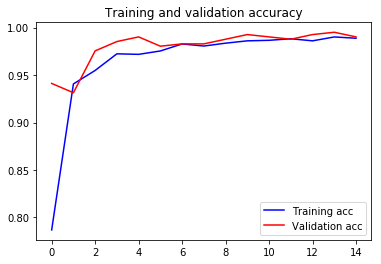

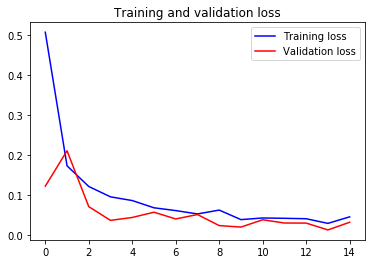

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### let us visually see the errors that we got.

In [25]:
# Create a generator for prediction
validation_generator = validation_datagen.flow_from_directory(
        "data/grape/val",
        target_size=(256, 256),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)
 
# Get the filenames from the generator
fnames = validation_generator.filenames
 
# Get the ground truth from generator
ground_truth = validation_generator.classes
 
# Get the label to class mapping from the generator
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
# Get the predictions from the model using the generator
predictions = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size,verbose=1) 


Found 408 images belonging to 4 classes.
41/40 [==============================] - 6s 153ms/step


In [26]:
import numpy as np
import PIL 
from keras.preprocessing import image

No of errors = 4/408


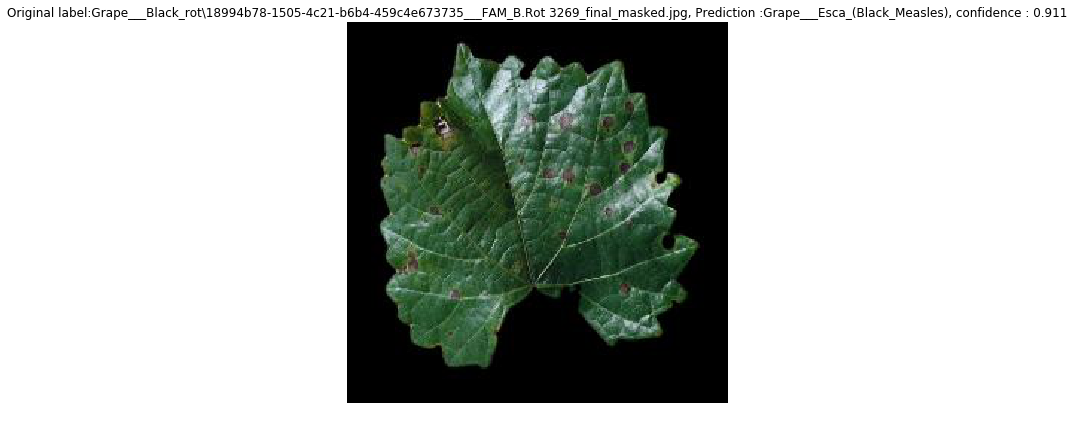

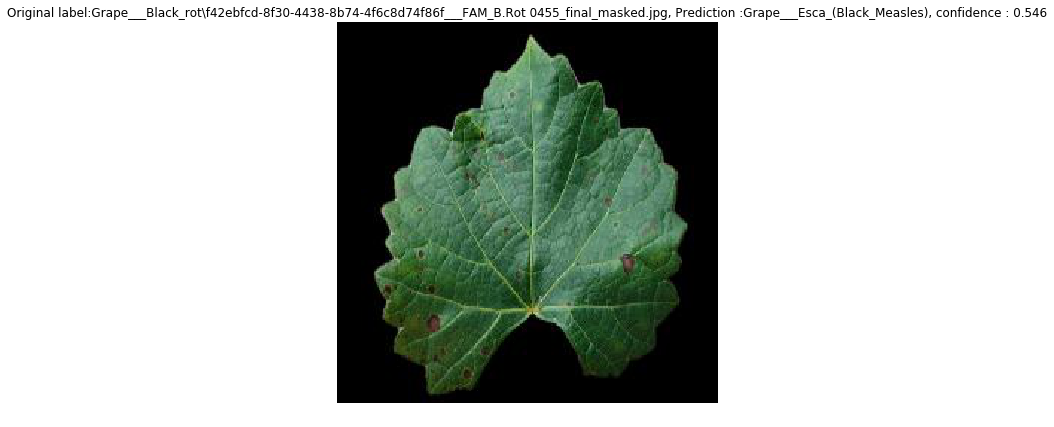

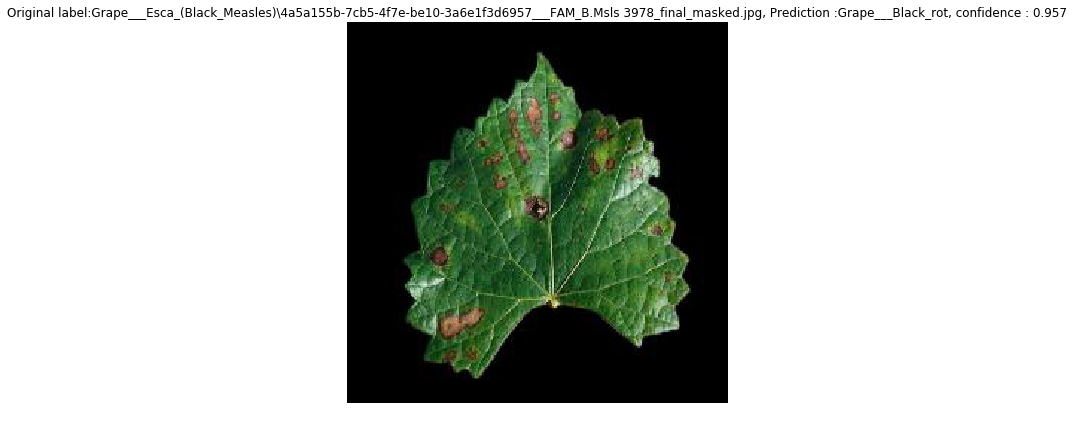

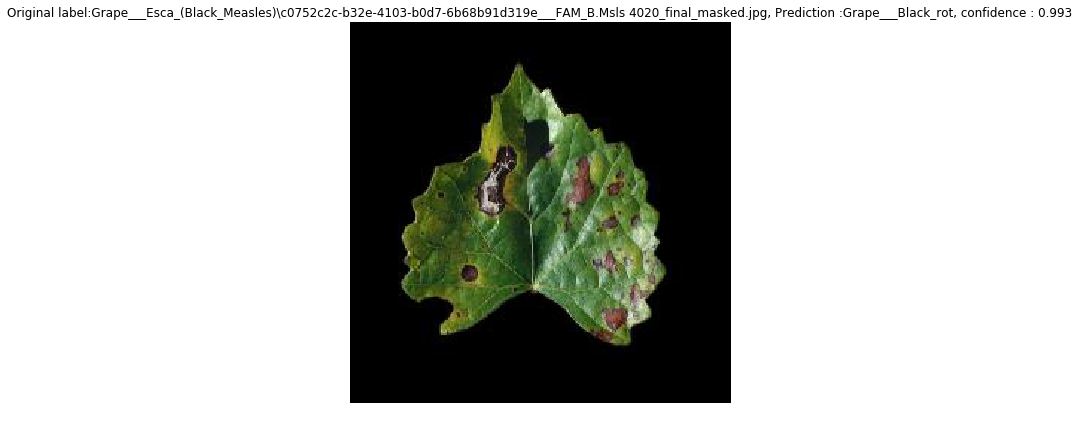

In [27]:
predicted_classes = np.argmax(predictions,axis=1)
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))
 
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
     
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class])
     
    original = image.load_img('{}/{}'.format("data/grape/val",fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
    plt.show()

## Predict Output

In [ ]:
# load json and create model
from keras.models import model_from_json
json_file = open('weights/VGG16/VGG16_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("weights/VGG16/vgg16_best.hdf5")
print("Loaded model from disk")

In [ ]:
loaded_model.summary()

In [ ]:
import cv2
from tqdm import tqdm
import itertools
import numpy as np
import matplotlib.pyplot as plt
import json

In [ ]:
im = cv2.imread("test images/orange_han.jpg")

In [ ]:
im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256))
plt.imshow(im)
im = np.expand_dims(im, axis =0)
im=cv2.normalize(im.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

In [ ]:
loaded_model.predict(im)

In [ ]:
outcome=loaded_model.predict(im)

In [ ]:
sum(outcome[0])

In [ ]:
np.argmax(outcome)

In [ ]:
with open('labels.json', 'r') as fp:
    data = json.load(fp)

In [ ]:
data[str(np.argmax(outcome))]

In [ ]:
from keras.models import model_from_json
import cv2
import numpy as np
import json

# loading model from json
json_file = open('weights/VGG16/VGG16_model.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model.load_weights("weights/VGG16/vgg16_best.hdf5")
#print("Loaded model from disk")

# file path
im = cv2.imread("test images/tomato_healthy.JPG")
im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256))
im = np.expand_dims(im, axis =0)

outcome = model.predict(im)

# loading labels file to convert to string
with open('labels.json', 'r') as fp:
    data = json.load(fp)

pred_disease=data[str(np.argmax(outcome))]
print("predicted output:",pred_disease)